In [1]:
import os
from pathlib import Path
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
BASE_DIR = Path.cwd().parent
os.chdir(BASE_DIR)

DATA = BASE_DIR / "data" / "smsspam_dataset.csv"
BASE = BASE_DIR / "results"

print("Diretório base:", BASE_DIR)
print("DATA existe:", DATA.exists())
print("RESULTS existe:", BASE.exists())

Diretório base: /home/corisco/llm-spam-benchmark
DATA existe: True
RESULTS existe: True


In [3]:
df_gt = pd.read_csv(DATA)
df_gt = df_gt[["id", "label"]].copy()
df_gt["label"] = df_gt["label"].str.strip().str.lower()

print(f"Dataset carregado: {len(df_gt)} exemplos.")

Dataset carregado: 5160 exemplos.


In [4]:
models = [p.name for p in BASE.iterdir() if p.is_dir()]
print("Modelos encontrados:", models)

Modelos encontrados: ['gpt-4.1-mini', 'gpt-3.5-turbo-0125', 'gpt-5-nano', 'gpt-5', 'gpt-5-mini', 'gpt-4o-mini', 'gpt-4.1']


In [5]:
results = []

for model in models:
    pred_path = BASE / model / "predictions.csv"
    if not pred_path.exists():
        print(f"{model}: arquivo predictions.csv não encontrado.")
        continue

    df_pred = pd.read_csv(pred_path)
    df_pred["prediction"] = df_pred["prediction"].str.strip().str.lower()
    df_merged = df_gt.merge(df_pred, on="id", how="inner")

    # Filtra apenas classes válidas
    df_merged = df_merged[df_merged["prediction"].isin(["ham", "spam"])]
    df_merged = df_merged[df_merged["label"].isin(["ham", "spam"])]

    if df_merged.empty:
        print(f"{model}: sem amostras válidas após filtragem.")
        continue

    y_true = df_merged["label"]
    y_pred = df_merged["prediction"]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label="spam", zero_division=0)
    rec  = recall_score(y_true, y_pred, pos_label="spam", zero_division=0)
    f1   = f1_score(y_true, y_pred, pos_label="spam", zero_division=0)
    mcc  = matthews_corrcoef(y_true, y_pred)

    # Taxa de falsos positivos (Blocked Hams)
    cm = confusion_matrix(y_true, y_pred, labels=["ham", "spam"])
    tn, fp, fn, tp = cm.ravel()
    bh = fp / (fp + tn) if (fp + tn) > 0 else 0

    results.append({
        "model": model,
        "samples": len(df_merged),
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "bh": bh,
        "mcc": mcc
    })

In [6]:
df_results = pd.DataFrame(results)
df_results[["accuracy","precision","recall","f1","bh","mcc"]] *= 100  # percentage
df_results = df_results.round(2)
display(df_results.sort_values("f1", ascending=False))

,model,samples,accuracy,precision,recall,f1,bh,mcc
3,gpt-5,5150,98.93,95.50,95.94,95.72,0.64,95.11
6,gpt-4.1,5160,98.68,93.09,96.57,94.80,1.02,94.07
0,gpt-4.1-mini,5160,98.20,89.73,96.57,93.02,1.57,92.07
4,gpt-5-mini,5055,98.18,92.20,93.36,92.78,1.13,91.74
2,gpt-5-nano,5160,97.38,85.16,95.64,90.10,2.37,88.79
1,gpt-3.5-turbo-0125,5157,95.58,74.58,97.82,84.64,4.74,83.14
5,gpt-4o-mini,5160,95.29,73.17,98.13,83.83,5.11,82.34


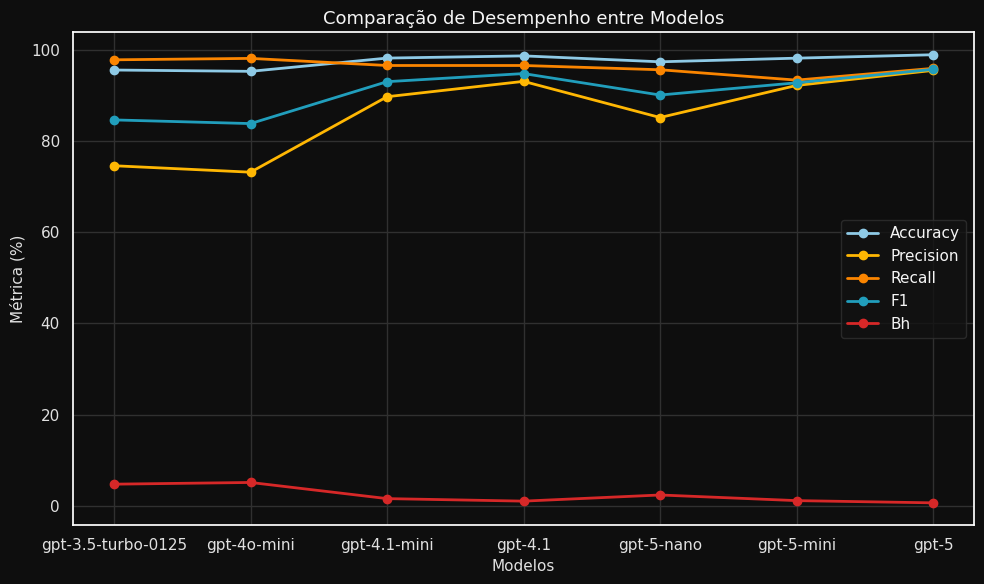

In [22]:
# === Preparação dos dados ===
df_results = pd.DataFrame(results).copy()
for col in ["accuracy","precision","recall","f1","bh"]:
    df_results[col] = df_results[col] * 100

# === Ordem fixa dos modelos ===
order = ["gpt-3.5-turbo-0125", "gpt-4o-mini", "gpt-4.1-mini","gpt-4.1","gpt-5-nano", "gpt-5-mini","gpt-5"]
df_results["model"] = df_results["model"].astype(str)
df_results = df_results.set_index("model").reindex(order).dropna(subset=["accuracy"]).reset_index()

# === Tema escuro ===
sns.set_theme(style="darkgrid", rc={
    "axes.facecolor": "#0e0e0e",
    "figure.facecolor": "#0e0e0e",
    "text.color": "#e0e0e0",
    "axes.labelcolor": "#e0e0e0",
    "xtick.color": "#e0e0e0",
    "ytick.color": "#e0e0e0",
    "grid.color": "#303030"
})

plt.figure(figsize=(10,6))
palette = {
    "accuracy":"#8ecae6",
    "precision":"#ffb703",
    "recall":"#fb8500",
    "f1":"#219ebc",
    "bh":"#d62828"
}

for metric, color in palette.items():
    plt.plot(df_results["model"], df_results[metric],
             marker="o", linewidth=2, color=color, label=metric.capitalize())

plt.title("Comparação de Desempenho entre Modelos", fontsize=13, color="#f5f5f5")
plt.xlabel("Modelos", fontsize=11)
plt.ylabel("Métrica (%)", fontsize=11)
plt.legend(facecolor="#121212", edgecolor="#303030", labelcolor="#f5f5f5")
plt.tight_layout()
plt.show()


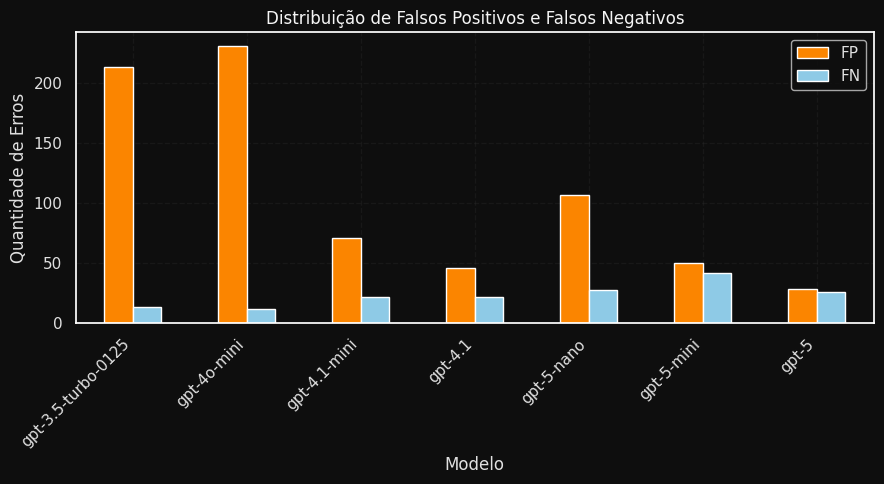

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Ordem fixa dos modelos ===
order = ["gpt-3.5-turbo-0125", "gpt-4o-mini", "gpt-4.1-mini","gpt-4.1","gpt-5-nano", "gpt-5-mini","gpt-5"]

# === Cálculo de FP e FN para cada modelo ===
stats = []
for model in order:
    pred_path = BASE / model / "predictions.csv"
    if not pred_path.exists():
        print(f"⚠️ {model}: predictions.csv não encontrado, ignorando.")
        continue

    df_pred = pd.read_csv(pred_path)
    df_pred["prediction"] = df_pred["prediction"].str.strip().str.lower()
    df_m = df_gt.merge(df_pred, on="id", how="inner")

    fp = np.sum((df_m["label"] == "ham") & (df_m["prediction"] == "spam"))
    fn = np.sum((df_m["label"] == "spam") & (df_m["prediction"] == "ham"))

    stats.append({"model": model, "FP": fp, "FN": fn})

# === Monta dataframe com a ordem correta ===
df_stats = pd.DataFrame(stats).set_index("model").reindex(order)

# === Gráfico de barras ===
df_stats.plot(kind="bar", stacked=False, figsize=(9,5), color=["#fb8500", "#8ecae6"])
plt.title("Distribuição de Falsos Positivos e Falsos Negativos", color="#f5f5f5")
plt.ylabel("Quantidade de Erros", color="#e0e0e0")
plt.xlabel("Modelo", color="#e0e0e0")
plt.xticks(rotation=45, ha="right", color="#e0e0e0")
plt.yticks(color="#e0e0e0")
plt.grid(True, linestyle="--", alpha=0.3)
plt.gcf().patch.set_facecolor("#0e0e0e")
plt.gca().set_facecolor("#0e0e0e")
plt.tight_layout()
plt.show()



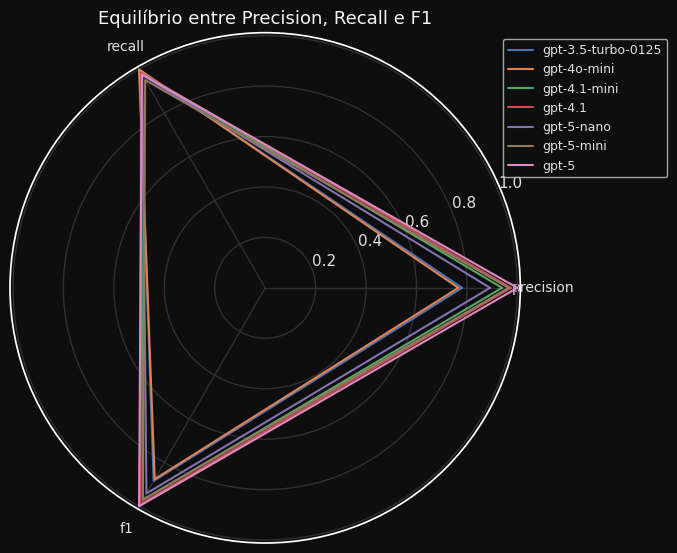

In [23]:
from math import pi
import matplotlib.pyplot as plt

# === Ordem fixa dos modelos ===
order = ["gpt-3.5-turbo-0125", "gpt-4o-mini", "gpt-4.1-mini", "gpt-4.1",
         "gpt-5-nano", "gpt-5-mini", "gpt-5"]

# === Seleciona e normaliza métricas ===
metrics = ["precision", "recall", "f1"]
df_radar = df_results.set_index("model").reindex(order)[metrics]
df_radar = df_radar / df_radar.max()  # normaliza 0–1

# === Configuração do gráfico polar ===
plt.figure(figsize=(7,7))
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

# === Plotagem ===
for i, (model, row) in enumerate(df_radar.iterrows()):
    if row.isnull().any():
        continue
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=model)

# === Estética ===
plt.xticks(angles[:-1], metrics, color="#e0e0e0", fontsize=10)
plt.title("Equilíbrio entre Precision, Recall e F1", color="#f5f5f5", fontsize=13)
plt.legend(bbox_to_anchor=(1.3, 1), fontsize=9)
plt.gcf().patch.set_facecolor("#0e0e0e")
plt.gca().set_facecolor("#0e0e0e")
plt.tight_layout()
plt.show()




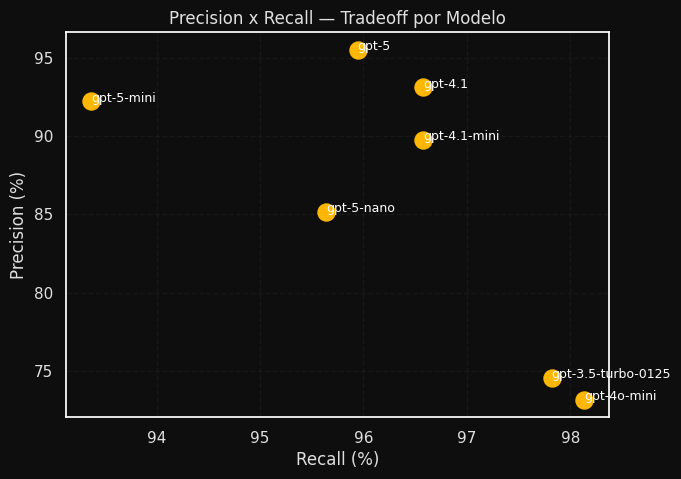

In [15]:
plt.figure(figsize=(7,5))
plt.scatter(df_results["recall"], df_results["precision"], s=150, color="#ffb703")

for _, row in df_results.iterrows():
    plt.text(row["recall"], row["precision"], row["model"], fontsize=9, color="white")

plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.title("Precision x Recall — Tradeoff por Modelo")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


📊 Gerando matriz de confusão para 7 modelos válidos nessa ordem:
['gpt-3.5-turbo-0125', 'gpt-4o-mini', 'gpt-4.1-mini', 'gpt-4.1', 'gpt-5-nano', 'gpt-5-mini', 'gpt-5']


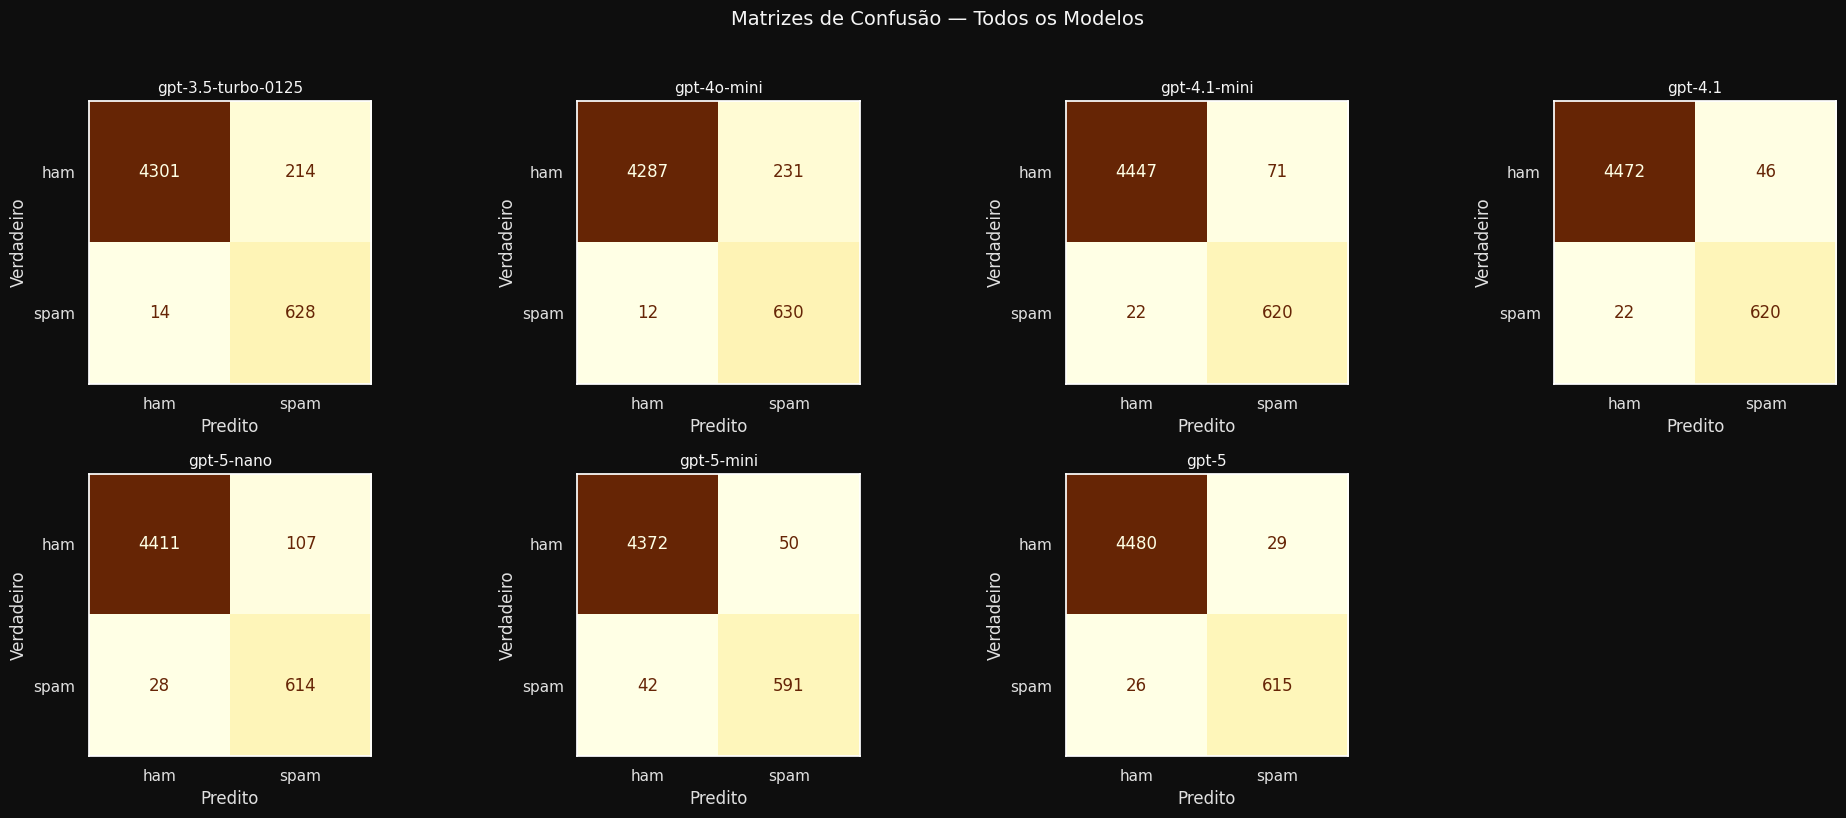

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# === Garante que o ground truth está carregado ===
if "df_gt" not in locals():
    df_gt = pd.read_csv(DATA)[["id", "label"]].copy()
    df_gt["label"] = df_gt["label"].str.strip().str.lower()

# === Ordem fixa desejada ===
order = ["gpt-3.5-turbo-0125", "gpt-4o-mini", "gpt-4o", "gpt-4.1-mini",
         "gpt-4.1", "gpt-5-nano", "gpt-5-mini", "gpt-5"]

# === Filtra apenas os modelos válidos na ordem especificada ===
valid_models = [m for m in order if (BASE / m / "predictions.csv").exists()]
print(f"📊 Gerando matriz de confusão para {len(valid_models)} modelos válidos nessa ordem:")
print(valid_models)

# === Define grid de subplots dinamicamente ===
cols = 4
rows = int(len(valid_models) / cols) + int(len(valid_models) % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

# === Loop pelos modelos ===
for i, model in enumerate(valid_models):
    ax = axes[i]
    pred_path = BASE / model / "predictions.csv"

    df_pred = pd.read_csv(pred_path)
    df_pred["prediction"] = df_pred["prediction"].str.strip().str.lower()
    df_merged = df_gt.merge(df_pred, on="id", how="inner")

    cm = confusion_matrix(df_merged["label"], df_merged["prediction"], labels=["ham", "spam"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
    disp.plot(ax=ax, cmap="YlOrBr", colorbar=False)

    ax.set_title(model, color="#f5f5f5", fontsize=11)
    ax.set_xlabel("Predito", color="#e0e0e0")
    ax.set_ylabel("Verdadeiro", color="#e0e0e0")
    ax.tick_params(colors="#e0e0e0")
    ax.grid(False)
    fig.patch.set_facecolor("#0e0e0e")
    ax.set_facecolor("#0e0e0e")

# === Remove eixos vazios ===
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Matrizes de Confusão — Todos os Modelos", color="#f5f5f5", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
